#  Anomaly Detection with Autoencoders

## Imports

In [168]:
import os
import random

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from pathlib import Path

from skimage.metrics import structural_similarity as ski_ssim
from pytorch_msssim import SSIM, MS_SSIM

#Setup device to GPU if possible
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Dataset select

Neural network will be trained on one of the MVTec available subsets as an example. For this case, "screw" dataset have been selected.

In [169]:
dataset_name = 'capsule' #Selected dataset contained in "data/" directory

train_dir = Path(f"data/{dataset_name}/train")
test_dir = Path(f"data/{dataset_name}/test")

## Parameters

In [170]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
IMG_RESIZE = 256 #Resize of an input images
INPUT_CROP  = 256 #Crop of resized images, when equal to resize value there is no crop applied
TRAINING_SIZE = 1000 #Number of images taken for training
TEST_SIZE = 100 #Number of images taken for testing

## Subdirectories dependencies viewer

In [171]:
def explore_dir(dir_path):
    """
    Function for exploring specified directory dependencies and number of images
    
    Args:
        dir_path (str or Path): Location of interested directory   
    """
    for current_dir, dirs, img in os.walk(dir_path):
        print(f"'{current_dir}' have {len(dirs)} directories and {len(img)} images.")
    print("")

explore_dir(train_dir)
explore_dir(test_dir)

'data\capsule\train' have 1 directories and 0 images.
'data\capsule\train\good' have 0 directories and 219 images.

'data\capsule\test' have 6 directories and 0 images.
'data\capsule\test\crack' have 0 directories and 23 images.
'data\capsule\test\faulty_imprint' have 0 directories and 22 images.
'data\capsule\test\good' have 0 directories and 23 images.
'data\capsule\test\poke' have 0 directories and 21 images.
'data\capsule\test\scratch' have 0 directories and 23 images.
'data\capsule\test\squeeze' have 0 directories and 20 images.



## View data

Random image path: data\capsule\test\poke\014.png
Image size: 1000x1000


(-0.5, 999.5, 999.5, -0.5)

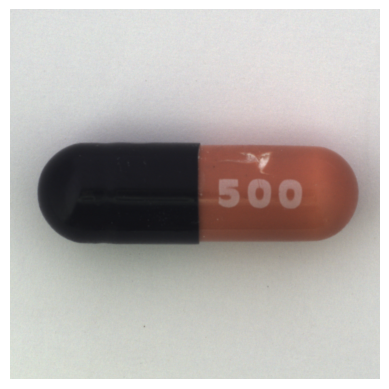

In [172]:
images_paths = list(test_dir.glob("*/*.png")) # Gets list of all images paths from train directory
random_image_path = random.choice(images_paths)
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image size: {img.height}x{img.width}") 

fig, ax = plt.subplots(1, 1)
plt.gray()
ax.imshow(img)
ax.axis("off")

## Data augmentation

In [173]:
data_transform = transforms.Compose([
    transforms.Resize(size=(IMG_RESIZE, IMG_RESIZE)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

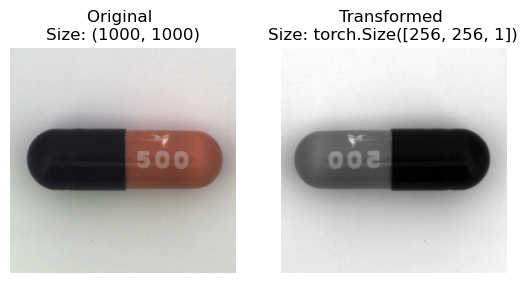

In [174]:
def image_transformation_plot(image_path, transform):
    """
    Plots and compares selected image before and after transformation.
    
    Args:
        image_path (Path): Path of image to plot
        transform (Pytorch Transforms): Selected transforms composition
    """
    f = Image.open(image_path)
    
    fig, ax = plt.subplots(1, 2)
    plt.gray()
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")
    
    transformed_image = transform(f).permute(1, 2, 0) 
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

image_transformation_plot(random_image_path, data_transform)

## Train and test datasets preparation

In [175]:
def random_crop(data_dir, N_train, crop, ):
    """
    Function for building dataset with randomly choosen images with applied random crop to (128,128) size.
    
    Args:
        data_dir (str or Path): Location of interested directory
        N_train (int): Number of images in prepared dataset 
    """
    crop_size = (crop, crop)

    train_data = []

    images_paths = list(data_dir.glob("good/*.png"))

    for i in range(0, N_train):
        random_image_path = random.choice(images_paths)
        img = Image.open(random_image_path)
        img = data_transform(img).squeeze(0)
        
        x_start = random.randint(0, img.shape[0]-crop_size[0])
        y_start = random.randint(0, img.shape[1]-crop_size[1])
        x_end = x_start + crop_size[0]
        y_end = y_start + crop_size[1]
        
        crop = img[x_start:x_end, y_start:y_end]
        crop = crop.type(torch.float32).unsqueeze(0)
        train_data.append(crop)

    return train_data

In [176]:
train_data = random_crop(data_dir=train_dir, N_train=TRAINING_SIZE, crop = INPUT_CROP)

test_data = random_crop(data_dir=test_dir, N_train=TEST_SIZE, crop = INPUT_CROP)

print(f"Image tensor:\n{test_data[0][0]}")
print(f"Image shape: {test_data[0][0].shape}")
print(f"Image datatype: {test_data[0][0].dtype}")

Image tensor:
tensor([[0.8118, 0.8118, 0.8118,  ..., 0.8627, 0.8549, 0.8510],
        [0.8157, 0.8157, 0.8157,  ..., 0.8588, 0.8510, 0.8471],
        [0.8157, 0.8157, 0.8157,  ..., 0.8510, 0.8549, 0.8471],
        ...,
        [0.8549, 0.8588, 0.8627,  ..., 0.8627, 0.8588, 0.8549],
        [0.8588, 0.8588, 0.8588,  ..., 0.8588, 0.8549, 0.8549],
        [0.8510, 0.8510, 0.8471,  ..., 0.8588, 0.8588, 0.8588]])
Image shape: torch.Size([256, 256])
Image datatype: torch.float32


## Dataloader

In [177]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle=True
                             )

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

images = next(iter(train_dataloader))
print(f"Image shape: {images.shape}\n {torch.min(images)}\n {torch.max(images)}")

Image shape: torch.Size([32, 1, 256, 256])
 0.0470588244497776
 0.9803921580314636


## Model

In [199]:
class autoencoder_v0(nn.Module):

    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = nn.Sequential( 
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 32, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d( 128, 500, 3, stride=1, padding=0)
        )

        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(500, 128, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d( 32, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    
    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
     
model = autoencoder_v0()

summary(model, input_size=[BATCH_SIZE, 1, INPUT_CROP, INPUT_CROP])

Layer (type:depth-idx)                   Output Shape              Param #
autoencoder_v0                           [32, 1, 256, 256]         --
├─Sequential: 1-1                        [32, 500, 6, 6]           --
│    └─Conv2d: 2-1                       [32, 32, 128, 128]        544
│    └─ReLU: 2-2                         [32, 32, 128, 128]        --
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          32,832
│    └─ReLU: 2-4                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-5                       [32, 128, 32, 32]         131,200
│    └─ReLU: 2-6                         [32, 128, 32, 32]         --
│    └─Conv2d: 2-7                       [32, 64, 16, 16]          131,136
│    └─ReLU: 2-8                         [32, 64, 16, 16]          --
│    └─Conv2d: 2-9                       [32, 128, 8, 8]           131,200
│    └─ReLU: 2-10                        [32, 128, 8, 8]           --
│    └─Conv2d: 2-11                      [32, 500, 6, 6]         

## Train loop

In [179]:
def train_step(model, dataloader, loss_fn, optimizer):

    model.train()
    train_loss = 0
        
    for batch, img in enumerate(dataloader):
        
        img = img.to(device)
        recon = model(img)
        loss = 1 - loss_fn(recon, img)
        train_loss += loss.item() 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(dataloader)
    
    return train_loss

In [180]:
def test_step(model, dataloader, loss_fn, epoch):

    model.eval()
    test_loss = 0
    
    with torch.inference_mode():
        for batch, img in enumerate(dataloader):

            img = img.to(device)
            recon = model(img)
            loss = 1 - loss_fn(recon, img)
            test_loss += loss.item() 
    
        test_loss = test_loss / len(dataloader)
#         outputs.append((epoch, img, recon))
    
    return test_loss

In [181]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs):
    
    results = {"train_loss": [], "test_loss": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              epoch=epoch)
        
        train_ssim = (1 - train_loss)*100
        test_ssim = (1 - test_loss)*100
        
 
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"train_ssim: {train_ssim:.2f}% | "
              f"test_ssim: {test_ssim:.2f}% | ")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)

    return results

# Training the Model

In [200]:
criterion = SSIM(win_sigma=1.5, data_range=1, size_average=True, channel=1)
# criterion = nn.MSELoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
NUM_EPOCHS = 40

In [201]:
model_results = train(model=model, 
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer=optimizer,
                      loss_fn=criterion, 
                      epochs=NUM_EPOCHS)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2850 | test_loss: 0.2749 | train_ssim: 71.50% | test_ssim: 72.51% | 
Epoch: 2 | train_loss: 0.2743 | test_loss: 0.2624 | train_ssim: 72.57% | test_ssim: 73.76% | 
Epoch: 3 | train_loss: 0.1890 | test_loss: 0.1186 | train_ssim: 81.10% | test_ssim: 88.14% | 
Epoch: 4 | train_loss: 0.0874 | test_loss: 0.0695 | train_ssim: 91.26% | test_ssim: 93.05% | 
Epoch: 5 | train_loss: 0.0597 | test_loss: 0.0572 | train_ssim: 94.03% | test_ssim: 94.28% | 
Epoch: 6 | train_loss: 0.0521 | test_loss: 0.0516 | train_ssim: 94.79% | test_ssim: 94.84% | 
Epoch: 7 | train_loss: 0.0483 | test_loss: 0.0498 | train_ssim: 95.17% | test_ssim: 95.02% | 
Epoch: 8 | train_loss: 0.0467 | test_loss: 0.0482 | train_ssim: 95.33% | test_ssim: 95.18% | 
Epoch: 9 | train_loss: 0.0455 | test_loss: 0.0475 | train_ssim: 95.45% | test_ssim: 95.25% | 
Epoch: 10 | train_loss: 0.0458 | test_loss: 0.0464 | train_ssim: 95.42% | test_ssim: 95.36% | 
Epoch: 11 | train_loss: 0.0442 | test_loss: 0.0456 | train_

Text(0, 0.5, 'Loss')

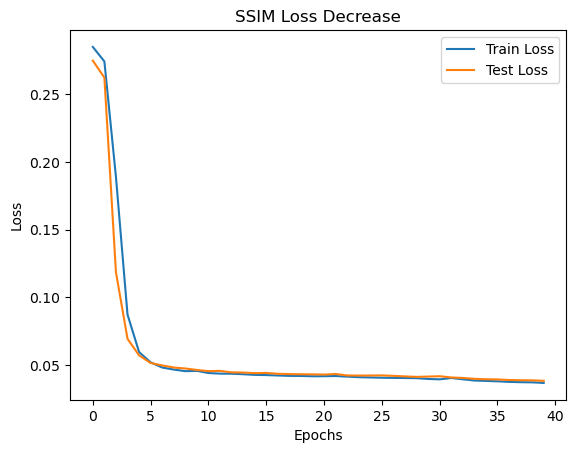

In [202]:
ax = pd.DataFrame({
    'Train Loss': [loss for loss in model_results['train_loss']],
    'Test Loss': [loss for loss in model_results['test_loss']]
}).plot(title='SSIM Loss Decrease')

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

## Show Anomalies on Test Data

In [203]:
# MODEL_PATH = Path("models")
# MODEL_NAME = "grid_500x3x3_bottleneck_96acc.pth"
# MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# loaded_model = autoencoder_v0()
# loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# loaded_model = loaded_model.to(device)

In [204]:
data_transform_test = transforms.Compose([
    transforms.Resize(size=(INPUT_CROP, INPUT_CROP)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

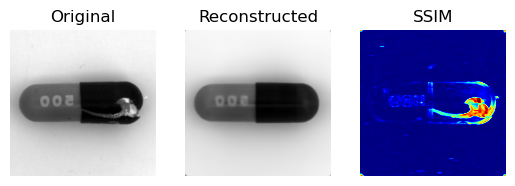

In [214]:
test_image_path = ("data/capsule/test/crack/001.png")
# test_image_path = ("data/capsule/train/good/019.png")

def image_reconstructed_plot(model: torch.nn.Module, 
                             image_path: str,  
                             transform=None,
                             device: torch.device = device):
    
    fig, ax = plt.subplots(1, 3)
    plt.gray()   
    
    img = Image.open(image_path)
    
    if transform:
        img_transformed = transform(img)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        input_image = img_transformed.unsqueeze(dim=0).to(device)
        reconstructed = model(input_image)
    
    original = img_transformed.permute(1, 2, 0).cpu()
    
    ax[0].imshow(original) 
    ax[0].set_title("Original")
    ax[0].axis("off")
    

    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu()
    ax[1].imshow(reconstructed) 
    ax[1].set_title("Reconstructed")
    ax[1].axis("off")
    
    img_old = np.array(original.squeeze(2))
    img_new = np.array(reconstructed.squeeze(2))
    _, S = ski_ssim(img_old, img_new, full=True, channel_axis=False)

    ax[2].imshow(1-S, vmax = 1, cmap='jet') 
    ax[2].set_title("SSIM")
    ax[2].axis("off")

    plt.axis(False);
    
image_reconstructed_plot(model=model,
                        image_path=test_image_path,
                        transform=data_transform,
                        device=device)

## Save model

In [156]:
MODEL_PATH = Path("models")
MODEL_NAME = "carpet_128x13x13_bottleneck_85acc.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving to: {MODEL_SAVE_PATH}")

torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving to: models\carpet_128x13x13_bottleneck_85acc.pth
